In [2]:
import mpmath as mp
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from mpmath import *
from mpl_toolkits.mplot3d import Axes3D
mp.dps = 15; mp.pretty = True
from numba import jit

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#tf.__version__

# Custom activation function
#from keras.layers import Activation
#from keras import backend as K
#from keras.utils.generic_utils import get_custom_objects

In [29]:
# Normalise X value with choosen range
def xnorm (x,maxrange,minrange):
    # Separate the dimensions
    n=[]
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        rex=(maxrange-minrange)/(np.max(temp)-np.min(temp))*(np.array(temp)-np.min(temp))+minrange
        n.append(rex)
    a=[]
    for i in range(x.shape[0]):
        r=[]
        for j in range(x.shape[1]):
            r.append(n[j][i])
        a.append(r)
    return np.array(a)

# Normalise Y value with choosen range
def ynorm (func,maxrange,minrange):
    rex=(maxrange-minrange)/(np.max(func)-np.min(func))*(np.array(func)-np.min(func))+minrange
    return rex

# Decode Normalised integrated value
def decode(func,x,maxrange,minrange,inte):
    v={}
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        v[j]=np.max(temp)-np.min(temp)
    product=1
    for i in range(x.shape[1]):
        product=product*v[i]
    vs=product
    vss=(maxrange-minrange)**x.shape[1]
    f=np.max(func)-np.min(func)
    yy=maxrange-minrange
    return vs*f*inte/(vss*yy)+(np.min(func)-f/yy*minrange)*vs

# Initial function
def init(dim):
    # number of function dimension
    dim = dim
    # training set of N
    N = 3000*dim**3
    # random x grid
    x = np.random.random((N,dim))
    # set the maximum dimension
    MAX_DIM=20
    # set the random variables of u and c
    np.random
    u = np.random.random((dim,))
    cs = np.random.random((MAX_DIM,))
    cs = cs[:x.shape[1]]
    return dim, N, x, u, cs

# function for fitting
# y value
def oscil(x):
    arg = np.dot(x,cs)
    arg += u[0] * 2 * np.pi
    return np.cos(arg)

def prod(x):
    temp={}
    for i in range(x.shape[1]):
        temp2=[]
        for j in range(x.shape[0]):
            temp2.append(x[j][i])
        temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
    product=1
    for i in range(x.shape[1]):
        product=product*temp[i]
    return product

# function graph
def graph(dim,x,y):
    if dim == 1:
        plt.scatter(x,y)
        plt.show()
    elif dim == 2:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1=[j[0] for j in x]
        x2=[j[1] for j in x]
        ax.scatter(x1, x2, y)
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        img = ax.scatter(x1, x2, x3, c=y, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    elif dim == 4:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        x4 = [j[3]*30 for j in x]
        img = ax.scatter(x1, x2, x3, c=y,s=x4, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()

# number of nodes (k) tunable parameter k1,k2
def node(dim,N):
    k1 = 4.33
    k2 = 16
    #k = math.floor(((np.log10(N)**(-k1))*(k2*N/(dim+2))))
    k = math.floor(10*dim*np.log10(N)**1.5)
    return k

# weight and bias of input and output
def sk_coe(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(dim):
        weight_input.append(mlpr.coefs_[0][i])
    return weight_input, weight_output, bias_input, bias_output

def tf_coe(mlpr):
    weight_input = []
    weight_output = mlpr.layers[1].get_weights()[0]
    bias_input = mlpr.layers[0].get_weights()[1]
    bias_output = mlpr.layers[1].get_weights()[1]
    for i in range(dim):
        weight_input.append(mlpr.layers[0].get_weights()[0][i])
    return weight_input, weight_output, bias_input, bias_output

# sign of sigmoid integration
def addIndex(l):
    ret = []
    for v in l:
        ret.append(v+[0])
        ret.append(v+[1])
    return ret 

def sigs(l):
    return int((-1)**(sum(l)-len(l)))

def sig_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)
    if n%2==0:
        signs = [sigs(x) for x in ret]
    else:
        signs = [-1*sigs(x) for x in ret]
    return ret, signs

def re_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)

    signs = [sigs(x) for x in ret]
    return ret, signs

# fixed input values
def inp(fix):
    return np.random.random((100,fix))

# numerical calculation of integral
# Sigmoid
def sig_integral(dim,fix):
    vecpoly = np.vectorize(fp.polylog, signature='(),()->()', otypes=[float])
    if fix > 0:
        dim=dim-fix
        cons=np.dot(inp(fix),weight_input[dim:])
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-(bias_input+cons)-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T[0],axis=1))
        return result
    else:
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-bias_input-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T[0]))[0]
        return result
# Relu
def re_integral(dim,fix):
    def relu(x):
        return np.clip(x,a_min=0.0, a_max=None)
    if fix > 0:
        temp=0
        dim=dim-fix
        cons=np.dot(inp(fix),weight_input[dim:])
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0)
        result=(bias_output+np.sum(temp*weight_output.T[0],axis=1))
        return result
    else:
        poly =[]
        temp=0
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+sum(weight.T))**(dim+1)/np.prod(weight_input,axis=0)
        result=(bias_output+np.sum(temp*weight_output.T[0]))[0]
        return result

# analytical integral value
# Oscillatory
def symbolicval(ndiff, nfix):
    arest = cs[ndiff:]
    adiff = cs[:ndiff]
    norm = 2**ndiff*np.prod(np.sin(adiff/2))/np.prod(adiff)
    arg = 2*np.pi*u[0] + sum(adiff)/2
    if nfix == 0:
        F = norm*np.cos(arg)
    else:
        F = norm*np.cos(arg+np.dot(inp(nfix),arest))
    return F

# Product peak
def symbolicval2(ndiff, nfix):
    temp=[]
    for i in range(ndiff):
        temp.append(cs[i]*(np.arctan(cs[i]*u[i])+np.arctan(cs[i]-cs[i]*u[i])))
    product=1
    for i in range(ndiff):
        product=product*temp[i]
    if nfix ==0:
        F=product
    else:
        temp={}
        for i in range(x.shape[1]):
            temp2=[]
            for j in range(x.shape[0]):
                temp2.append(x[j][i])
            temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
        product2=1
        for i in range(nfix):
            product2=product2*temp[i+nfix]
            F=product2
        return F*prod(x)
    return F

size of x, cs and u
(24000, 2)
(2,)
(2,)
original function graph(dim<=4)


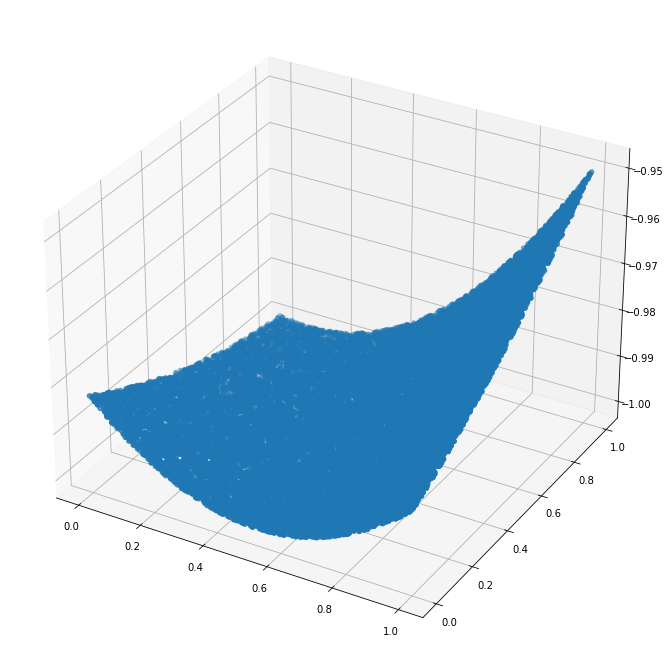

number of nodes
183
Y Min: -0.9999999999994793 Y Max: -0.9496074167216171


In [23]:
# Original values
dim, N, x, u, cs = init(2)
y = oscil(x)
#y = prod(x)
# test and validation divide 95%
trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
k = node(dim,N)

print('size of x, cs and u')
print(x.shape)
print(cs.shape)
print(u.shape)
print('original function graph(dim<=4)')
graph(dim,x,y)
print('number of nodes')
print(k)
print('Y Min:',np.min(y),'Y Max:',np.max(y))

In [24]:
# Keras fitting sigmoid
model = keras.Sequential([
    keras.layers.Dense(k, activation='sigmoid'),
    keras.layers.Dense(1)
])

# Keras custom activation fitting
def custom_activation(x):
    return x**3

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

model2 = keras.Sequential([
    keras.layers.Dense(k),
    keras.layers.Dense(1)
])
model2.add(Activation(custom_activation, name='SpecialActivation'))

# Keras sigmoid backpropagation
model.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Keras Custom activation backpropagation
model2.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Fitting
#model.fit(trainx, trainy, epochs=100)
#model2.fit(trainx, trainy, epochs=100)

NameError: name 'keras' is not defined

In [25]:
start = timeit.default_timer()
# mlpregression with Sigmoid activation adam backpropagation
mlp_reg = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'lbfgs', learning_rate_init=0.001,
                       learning_rate ='adaptive', tol=1e-10)
# fitting NN
mlp_reg.fit(trainx, trainy)
#print('convergence: ',len(mlp_reg.loss_curve_))
#print('loss: ', mlp_reg.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  0.7076850419980474


In [26]:
start = timeit.default_timer()
# mlpregression with relu activation with changed hyperparameter lbfgs
mlp_reg_re_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_re_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  43
Time:  1.6129283329937607


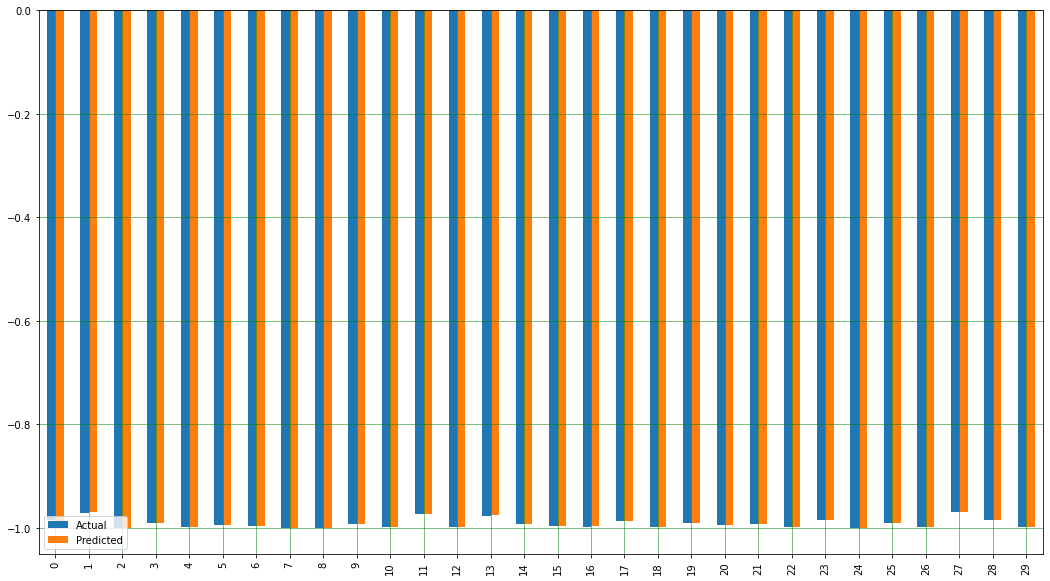

Mean Absolute Error: 0.0005191464671057824
Mean Squared Error: 4.5013280878556376e-07
Root Mean Squared Error: 0.0006709193757714586


In [27]:
# Prediction
y_pred = mlp_reg_re_lb.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
#plt.plot(mlp_reg_re_lb.loss_curve_)
#plt.title("Loss Curve", fontsize=14)
#plt.xlabel('Iterations')
#plt.ylabel('Cost')
#plt.yscale('log')
plt.show()

In [30]:
print(dim)
sy=symbolicval(dim,0)
print('Analytic_Oscil: ',sy)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
sig_lb=re_integral(dim,0)
print('Sigmoid_lbsfg: ',sig_lb)
#weight_input, weight_output, bias_input, bias_output = tf_coe(model)
#sig_tf=tf_integral(dim,0)
#print('Sigmoid_tensorflow: ',sig_tf)

rulu=inp(1)
sy_f=symbolicval(dim-1,1)
print('Analytic_fix_Oscil: ',sy_f)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
start = timeit.default_timer()
re_lb_f=re_integral(dim,1)
stop = timeit.default_timer()
print('Relu_lbsfg_fix: ',re_lb_f)
print('Time: ', stop - start)  


2
Analytic_Oscil:  -0.9915685770529089
Sigmoid_lbsfg:  -0.9915151099885746
Analytic_fix_Oscil:  [-0.98773136 -0.98611837 -0.98834852 -0.98874079 -0.98924915 -0.99196693
 -0.98688376 -0.99414765 -0.99417414 -0.99041823 -0.9917443  -0.99149038
 -0.99094967 -0.98539877 -0.98899724 -0.98669472 -0.98845474 -0.9923253
 -0.99415028 -0.99475461 -0.988408   -0.99226376 -0.99283098 -0.99387393
 -0.99358109 -0.99476836 -0.98682439 -0.99464973 -0.99076145 -0.99463581
 -0.99460846 -0.99459708 -0.98894615 -0.99315948 -0.98632563 -0.98630757
 -0.99399309 -0.989887   -0.98919674 -0.99443049 -0.99150613 -0.99192109
 -0.99386212 -0.99426082 -0.98989463 -0.98929381 -0.99129507 -0.99319201
 -0.98642027 -0.98616281 -0.99082775 -0.9856424  -0.99416723 -0.99410303
 -0.99357895 -0.99470164 -0.99276601 -0.99361558 -0.99465873 -0.99420638
 -0.99370818 -0.99435804 -0.99467495 -0.99154125 -0.98931886 -0.99476489
 -0.98810681 -0.99035428 -0.99062664 -0.98938625 -0.99347559 -0.99432259
 -0.99144236 -0.99182281 -0.9